### **Multi-lable Text Classification Model with Single Output Layer**



---



---



In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from tensorflow.keras.layers import concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('output/Amazon_reviews_Multi_labels.csv')
df.head()

,star_rating,review,sentiment_score,review_category,Text,positive,negative,neutral,product,delivery,packaging
0,5,CHOOSE THE RIGHT COLORING PENCILS This is th...,positive,product,choose right list item use beautiful intricate...,1,0,0,1,0,0
1,5,"Great Taste, A Little Complicated I'll start b...",positive,product,great taste start say book amazing world good ...,1,0,0,1,0,0
2,5,Beyond Science and Religion...Endorsement and ...,positive,product,beyond religion endorsement support another su...,1,0,0,1,0,0
3,5,A truly unique work for this generation EDIT: ...,positive,product,unique edit point ridiculous literally purchas...,1,0,0,1,0,0
4,5,Stop kissing frogs 🐸 🐸 🐸 🐸 I've been trying Pa...,positive,product,stop kiss frog try paleo grain free cookbook s...,1,0,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516422 entries, 0 to 516421
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   star_rating      516422 non-null  int64 
 1   review           516422 non-null  object
 2   sentiment_score  516422 non-null  object
 3   review_category  516422 non-null  object
 4   Text             516422 non-null  object
 5   positive         516422 non-null  int64 
 6   negative         516422 non-null  int64 
 7   neutral          516422 non-null  int64 
 8   product          516422 non-null  int64 
 9   delivery         516422 non-null  int64 
 10  packaging        516422 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 43.3+ MB


In [4]:
review_labels = df[['positive', 'negative', 'neutral', 'product', 'delivery', 'packaging']]

<AxesSubplot:>

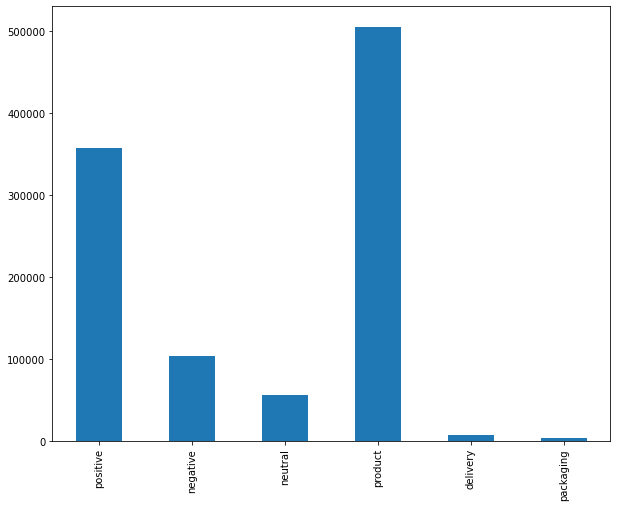

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

review_labels.sum(axis=0).plot.bar()

In [6]:
X = list(df["Text"])
Y = review_labels.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [9]:
# from nltk.tokenize import word_tokenize

# word_count = lambda sentence: len(word_tokenize(sentence))
# longest_sentence = max(X, key=word_count)
# length_long_sentence = len(word_tokenize(longest_sentence))
# length_long_sentence

3719

In [10]:
maxlen =3719  # length_long_sentence #3719

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('output/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
deep_inputs = Input(shape=(maxlen,))

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_Layer_1 = LSTM(128)(embedding_layer)

dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)

model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3719)]            0         
                                                                 
 embedding (Embedding)       (None, 3719, 100)         26441000  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 26,559,022
Trainable params: 118,022
Non-trainable params: 26,441,000
_________________________________________________________________
None


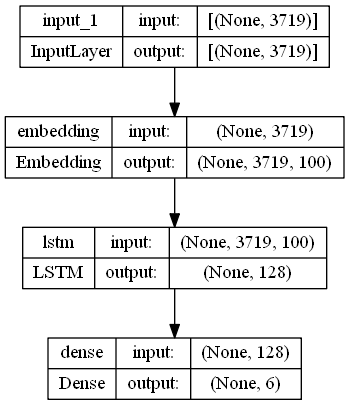

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [25]:
# !pip install pydot

In [26]:
# ! pip install graphviz

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Added early stopping system to monnitor validation loss on each epoch and stops training when 
# validation loss start to increase

monitor = EarlyStopping(monitor='val_loss', 
                        patience=5, 
                        mode='min',
                        restore_best_weights=True)

# Saving the model in every epochs for some experiments
checkpoint = ModelCheckpoint(filepath="output/model.{epoch:02d}-{val_loss:.2f}.h5")

In [ ]:
# Starting the training process
history = model.fit(X_train, y_train, batch_size=128, epochs=5, 
                    verbose=1, validation_split=0.2, callbacks=[monitor, checkpoint])

In [ ]:
# Saving the model
model.save('output/model_best.h5')